In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel
import h5py
import os

# For to fancy
import fakedata as fd
import cortex as cx

# For to machine learn
from sklearn import svm
from sklearn import discriminant_analysis as da

%matplotlib inline

# Dead simple classifier

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


(-2.610398428811749, 4.092973533324023, -3.3713827104533154, 2.763940399895608)

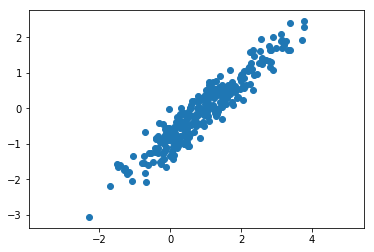

In [49]:
mu = np.array([1, 0])
cov = np.array([[1, 0.9],
                [0.9, .7]])
x = np.random.multivariate_normal(mu, cov, size=(300,))
plt.scatter(*x.T)
plt.axis([-4,4,-4,4])
plt.axis('equal')

A little basic algebra review...

You can have a line in the form of 

$y = mx + b$

Or you can have a line in the form of 

$0 = Ax + By + C$

... and if you have the latter, then 

$m = -A/B$ 

and

$b = -C/B$

(-4.4, 4.4, -4.4, 4.4)

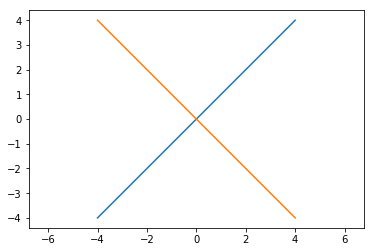

In [24]:
# Perpendicular lines
x = np.linspace(-4, 4, 100)
q = 1
y1 = q * x
y2 = -1/q * x
plt.plot(x, y1)
plt.plot(x, y2)
plt.axis('equal')

In [20]:
def generate_data(n, mu_c1, mu_c2, cov_c1=0.5, cov_c2=0.5, trn_frac=0.8):
    """For 2 classes only, 2D variables
    n is number per class
    corr_mag is correlation btw 1st and 2nd dim
    slope is magnitude of 1st dim / 2nd dim
    mu_c1 and mu_c2 are means for each dimension of X1 and X2"""
    if cov_c1 is None:
        cov_c1 = np.array([[1, 0], [0, 1]])
    elif not isinstance(cov_c1, np.ndarray):
        cov_c1 = np.array([[1, cov_c1], [cov_c1, 1]])
    if cov_c2 is None:
        cov_c2 = np.array([[1, 0], [0, 1]])
    elif not isinstance(cov_c2, np.ndarray):
        cov_c2 = np.array([[1, cov_c2], [cov_c2, 1]])
    # First variable
    X1 = np.random.multivariate_normal(mu_c1, cov_c1, size=(n,))
    # Second variable
    X2 = np.random.multivariate_normal(mu_c2, cov_c2, size=(n,))    
    nn = np.int(n*trn_frac)
    Xt = np.vstack([X1[:nn], X2[:nn]])
    Xv = np.vstack([X1[nn:], X2[nn:]])
    Yt = np.hstack([np.ones(nn), np.ones(nn)*2])
    Yv = np.hstack([np.ones((n-nn,)), np.ones((n-nn,))*2])
    return Xt, Xv, Yt, Yv

def plot_classes(X1, X2, classifier=None, axis=(-5, 5, -5, 5), clfcolor='k', plot_data=True, ax=None):
    """For now: only linear classifier, only w/ 2D plots"""
    if ax is None:
        fig, ax = plt.subplots()
    if plot_data:
        ax.scatter(X1[:,0], X1[:,1], color='r', alpha=0.3)
        ax.plot(*mu_c1, color='r', marker='o', markeredgecolor='k')
        ax.scatter(X2[:,0], X2[:,1], color='b', alpha=0.3)
        ax.plot(*mu_c2, color='b', marker='o', markeredgecolor='k')
        ax.axis(axis)
    if classifier is not None:
        # useful: https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
        w = classifier.coef_[0]
        # Slope (m from y = mx + b)
        m = -w[0] / w[1]
        # Get intercept (b from y = mx + b)
        b = - (classifier.intercept_[0]) / w[1]
        # Sample some X values, and compute the corresponding Ys
        xx = np.linspace(-5, 5)
        yy = m * xx + b
        ax.plot(xx, yy, clfcolor+'-')

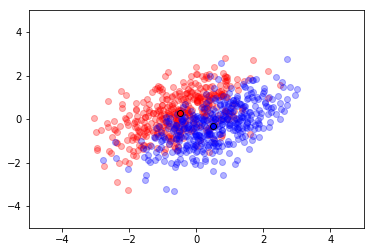

In [21]:
# Define 2D values for class 1
n = 500 # number of exemplars per class
r = 0.6
mu_c1 = np.array([-0.5, 0.3])
mu_c2 = np.array([0.5, -0.3])
Xt, Xv, Yt, Yv = generate_data(n, mu_c1, mu_c2, cov_c1=r, cov_c2=r)

plot_classes(Xt[Yt==1], Xt[Yt==2])

In [22]:
# Get SVM classifier base object
svmclf = svm.LinearSVC()
# Fit SVM classifier to data
_ = svmclf.fit(Xt, Yt)
# Predict new values
Ypred_svm = svmclf.predict(Xv)
# Show accuracy
np.mean(Ypred_svm==Yv)

0.845

In [23]:
ldaclf = da.LinearDiscriminantAnalysis()
# Fit LDA classifier to data
_ = ldaclf.fit(Xt, Yt)
# Predict new responses w/ LDA classifier
Ypred_lda = ldaclf.predict(Xv)
# Show accuracy
print(np.mean(Ypred_lda==Yv))

0.85


In [10]:
print(ldaclf.coef_)
print(ldaclf.intercept_)

[[ 2.1023007 -1.7309581]]
[0.10487786]


In [27]:
# Show slope & intercept of decision plane line for lda
print('Slope = %0.2f'%(- ldaclf.coef_[0][0]/ldaclf.coef_[0][1]))
print('Intercept = %0.2f'%(- ldaclf.intercept_[0]/ldaclf.coef_[0][1]))

Slope = 1.10
Intercept = -0.02


In [28]:
# Show slope & intercept of decision plane line for svm
print('Slope = %0.2f'%(- svmclf.coef_[0][0]/svmclf.coef_[0][1]))
print('Intercept = %0.2f'%(- svmclf.intercept_[0]/svmclf.coef_[0][1]))

Slope = 1.09
Intercept = -0.03


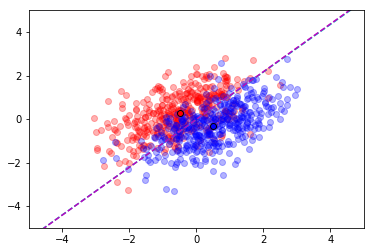

In [30]:
fig, ax = plt.subplots()
plot_classes(Xt[Yt==1], Xt[Yt==2], classifier=svmclf, clfcolor='c-', ax=ax)
plot_classes(Xt[Yt==1], Xt[Yt==2], classifier=ldaclf, clfcolor='m-', plot_data=False, ax=ax)

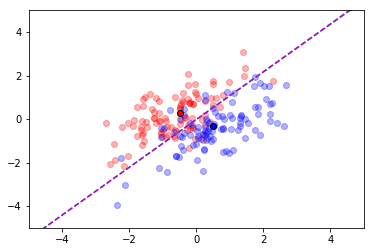

In [32]:
fig, ax = plt.subplots()
plot_classes(Xv[Yv==1], Xv[Yv==2], classifier=svmclf, clfcolor='c-', ax=ax)
plot_classes(Xv[Yv==1], Xv[Yv==2], classifier=ldaclf, clfcolor='m-', plot_data=False, ax=ax)

Let's mess with the classifier. 

In [ ]:
n = 500 # number of exemplars per class
na = 350
nb = 150
r = 0.6
ra = 0.6
rb = 0.65
mu_c1 = np.array([-0.5, 0.3])
mu_c2a = np.array([0.5, -0.3])
mu_c2b = np.array([0.9, -0.5])
Xt, Xv, Yt, Yv = generate_data(n, mu_c1, mu_c2, cov_c1=r, cov_c2=r)

plot_classes(Xt[Yt==1], Xt[Yt==2])

Use LO Localizer in a classification experiment.

In [29]:
subject = 's03'
transform = 'category_localizer'
roi_masks = cx.get_roi_masks('s03', 'category_localizer', roi_list=['V1','V2','V3','V4','LO','OFA','FFA','EBA',
                                                                   'PPA','RSC','OPA'])
mask = np.any(np.array(list(roi_masks.values())), axis=0)
#cx.webgl.show(cx.Volume(mask, subject, transform))

/home/mark/.local/lib/python3.5/site-packages/cortex/svgoverlay.py:496: UserWarning: Shapely error - computing mean of points instead of geometric center
  warnings.warn("Shapely error - computing mean of points instead of geometric center")


Cutting 15 overlapping voxels (should be < ~50)


In [35]:
fdir = '/unrshare/LESCROARTSHARE/IntroToEncodingModels/'
fbase = os.path.join(fdir, 's03_catloc_run%02d.nii.gz')
data = []
for run in range(1, 7):
    nii = nibabel.load(fbase%run)
    tmp = nii.get_data().T
    data.append(tmp[:, mask])

In [124]:
with h5py.File(os.path.join(fdir, 'catloc_design.hdf')) as hf:
    print(list(hf.keys()))
    X = hf['X'].value
    xnames = hf['xnames'].value.tolist()
    class_names = ['null'] + [x.decode() for x in xnames]
    events = hf['events'].value

['X', 'events', 'xnames']


In [93]:
clip_idx = np.ones((720,)) > 0
clip_idx[0:720:10] = False

In [94]:
for ci in [1, 8,9]:
    clip_idx[ci:720:10] = False

In [97]:
x, = np.nonzero(~clip_idx)

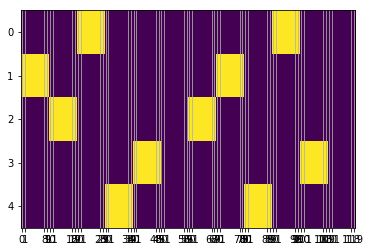

In [99]:
plt.imshow(X.T[:, :120], aspect='auto')
plt.xticks(x[x<120]) #np.arange(-0.5, 121, 10))
plt.grid(axis='x')

In [37]:
data[1].shape

(120, 5844)

In [106]:
clf = svm.LinearSVC()

In [107]:
clf.fit(vox[:72*4], e[:72*4])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [46]:
clf.fit(np.vstack(data[:4]), events[:120*4])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [47]:
out = clf.predict(data[-1])

In [108]:
out2 = clf.predict(vox[72*4:])
val_real = e[72*4:]

In [111]:
np.mean(out2==val_real)

0.6597222222222222

In [117]:
from sklearn import metrics

In [122]:
cm = metrics.confusion_matrix(val_real, out2)

In [129]:
class_names

['null', 'body', 'faces', 'object', 'places', 'scrambled']

In [130]:
ax.get_xticks()

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

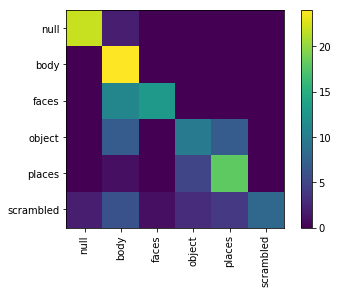

In [133]:
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)
plt.colorbar(im)

In [ ]:
subject = 's03'
transform = 'category_localizer'
roi_masks = cx.get_roi_masks('s03', 'category_localizer', roi_list=['V1','V2','V3','V4','LO','OFA','FFA','EBA',
                                                                   'PPA','RSC','OPA'])

In [104]:
n_per_run = clip_idx[:120].sum()

In [105]:
n_per_run

72

In [100]:
e = events[clip_idx]
events[-120:]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [102]:
vox = np.vstack(data)[clip_idx]

In [103]:
vox.shape

(432, 5844)

In [49]:
print(out==events[-120:])

[False False False False False False False False False False False False
  True  True  True False False False False False False  True  True False
 False False False False False False False False False  True False False
 False False False False False  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True  True False False False False  True  True  True  True  True  True
  True  True  True  True False False False False  True False False False
 False  True False  True  True  True  True  True  True  True  True  True]


In [77]:
clf_wts = dict()
for i, cname in enumerate([b'null',]  + xnames):
    clf_wts[cname.decode()] = cx.Volume(clf.coef_[i], subject, transform, 
                                        mask=mask, vmin=-0.0005, vmax=0.0005)

In [72]:
list(clf_wts.keys())

['places', 'faces', 'scrambled', 'object', 'body', 'null']

In [78]:
cx.webgl.show(clf_wts)

Started server on port 29563


<JS: window.viewer>

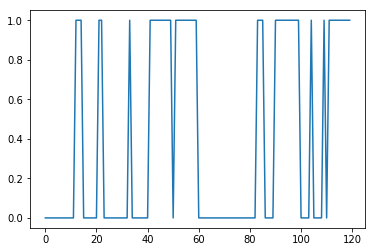

Stopping server


In [76]:
plt.plot(out==events[-120:])